In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import torch
import pickle
import os

In [3]:
def import_data(filepath, processor, max = -1):
    output_data = []
    output_name = []
    for iter, file in enumerate(os.listdir(filepath)):
     filename = os.fsdecode(file)
     if filename.endswith(".tif"):
         out = cv2.imreadmulti(filepath + '/' + filename)[1]
         output_data.append(processor(out))
         output_name.append(filename)
         if iter > max and max > 0: break
         continue
     else:
         continue
    return output_data, output_name

def process_brain(brain_seq):
  try:
    brain_seq = np.array(brain_seq)
    brain_mask = (np.sum(brain_seq, axis=0) > 0)
    flat_seq = (brain_seq[:, brain_mask])
    return flat_seq.astype(float)
  except:
    print(np.shape(brain_seq))

In [4]:
neural_data_test, name_data_test = import_data("2020_12_4_MV1_run_brain", process_brain)

In [5]:
neural_data_train, name_data_train = import_data("2020_11_9_MV1_run_brain", process_brain)

In [6]:
multi_cebra_model = cebra.CEBRA.load('cebra_multi_model2.pt')

In [7]:
def generate_CEBRA_embeddings(neural, name, model, session = 'run'):
    embedding = []
    failed = []
    for run, data in enumerate(neural):
        try:
            if session == 'run':
                run_data = (model.transform(data, session_id=run))
            else:
                run_data =(model.transform(data, session_id=2))
            embedding.append(run_data)
        except:
            failed.append(run)
            print(run)
    failed.reverse()
    for index in failed:
        del name[index]
        del neural[index]
    return embedding

In [8]:
neural_embedding_test = generate_CEBRA_embeddings(neural_data_test, name_data_test, multi_cebra_model, 'test')

5
6
12
18
19
20
27
28
29
40
41
43
57
76
77
84
85
99
114
125
129
132
134
138
143
163
164
188
213
226
229
230
244
260
270
275
289
293
295
303
313
323
330
343
351
363
367
375
385
392
396
415
427
435
460
466
469
477
480
485
498
512
525
527
534
535
540
549


In [9]:
with open('2020_12_4_CEBRA_embeddings.pb', 'rb') as f:
    test_data = pickle.load(f)
with open('2020_11_9_CEBRA_embeddings.pb', 'rb') as f:
    train_data = pickle.load(f)

In [10]:
neural_embedding_train = train_data[0]
name_train = train_data[1]
# neural_embedding_test = test_data[0]
# name_test = test_data[1]

In [11]:
def flatten_data(data):
    data_flat = (data[0])
    for x in data[1::]:
        data_flat = np.concatenate((data_flat, x))
    return data_flat

In [12]:
neural_embedding_test_flat = flatten_data(neural_embedding_test[:100])
neural_embedding_train_flat = flatten_data(neural_embedding_train[:100])

In [13]:
len(neural_embedding_test_flat)

21514

In [14]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering

In [15]:
clusterer = AgglomerativeClustering(n_clusters=3, metric='cosine', linkage='average')
clusterer.fit(neural_embedding_train_flat)
labels = clusterer.labels_

In [16]:
def reshape_flat(flat, shape_ref):
    shape_list = [np.shape(x)[0] for x in shape_ref]
    out = []
    index = 0
    for shape in shape_list:
        out.append((flat[index : index + shape]))
        index += shape
    return out

In [17]:
vid_labels = reshape_flat(labels, neural_embedding_train[:100])

In [18]:
def process_vids(folder, namelist, labels):
    fontScale = 1
    org = (50, 50)
    font = cv2.FONT_HERSHEY_SIMPLEX
    thickness = 2
    for clip_data in zip(namelist, labels):
        video_writer = cv2.VideoWriter('output_videos3/' +'label'+ str(np.round(np.median(clip_data[1]))) + clip_data[0] +'.mp4',
                                   cv2.VideoWriter_fourcc(*'mp4v'),
                                   30,
                                   (320, 320))
        vid = cv2.imreadmulti(folder + '/' + clip_data[0])[1]
        for label in zip(clip_data[1], vid):
            colored = cv2.cvtColor(label[1].astype(np.uint8), cv2.COLOR_GRAY2RGB)

            colored = cv2.putText(colored, str(label[0]), org, font, 
                   fontScale, (0,0,255), thickness, cv2.LINE_AA)
            video_writer.write(colored)
        video_writer.release()
        


In [78]:
process_vids('2020_11_9_MV1_run_behavior', name_train, vid_labels)

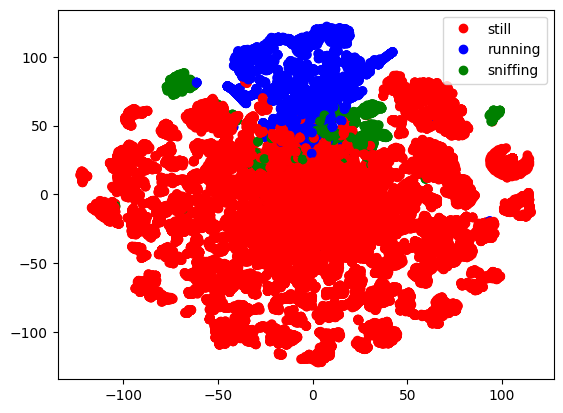

In [27]:
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=30).fit_transform(neural_embedding_train_flat)
colors = ListedColormap(['r','b','g'])
classes = ['still', 'running', 'sniffing']
#plot tsne plot as a scatterplot with labels
scatter = plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=labels, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()




'green'